**Gaussian processes**
---

A Gaussian Process defines a prior distribution over functions, as data points are observed, it will result in a posterior distribution over functions. It is specified by a mean function and a covariance function:

$$
f(\textbf{x}) \sim \mathcal{GP}(m(\textbf{x}), \kappa(\textbf{x},\textbf{x}{\prime}))
$$

Most of the time, we have a limited view on what to expect as a prior distribution, therefore the mean function is often assumed to be zero, so the distribution is centered at the origin. 

$$
m(\textbf{x}) = E[f(\textbf{x})] = \textbf{0}
$$

In the introduction exercises of this practical session, we'll use the RBF kernel as covariance function

$$
\kappa(\textbf{x},\textbf{x}^{\prime}) = \sigma^{2}\exp\bigg(-\frac{(\textbf{x}-\textbf{x}^{\prime})^{T}(\textbf{x}-\textbf{x}^{\prime})}{2\textit{l}^{2}}\bigg)
$$





## **Gaussian Process Regression**

The first part of the [following code](https://www.cs.ubc.ca/~nando/540-2013/lectures/gp.py) (from Nando de Freitas’ UBC [Machine Learning lectures](https://www.cs.ubc.ca/~nando/540-2013/lectures.html)) shows how to set up a prior distribution over functions that are evaluated at some evenly spaced points. In the second part, noiseless training data is used to get to the posterior distribution and samples are drawn from this posterior distribution.

*FYI (to understand the code):*

In practice, the prior distributions are sampled as a product of the standard normal distribution and the square root of the covariance matrix (kernel function) $L = K^{-1}$ with  $K = \kappa(\textbf{x},\textbf{x}^{\prime})$:

$$
f_{prior}(\textbf{x}) =  \mathcal{N}(0,1) L
$$

Where $L$ is determined from what is called the 'Cholesky decomposition': 

$$
 K = L^{T}L
$$

*Start with running the code below to visualize some prior distributions* $f_{prior}$: 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

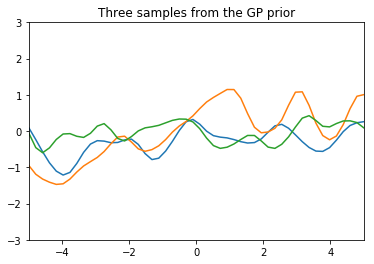

In [2]:
# Test data: Evaluate functions at 50 points between -5 and 5
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, sigma, l):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return sigma**2 * np.exp(-.5 * (1/l**2) * sqdist)
 
sigma = 0.5
l = 0.5


K_ss = kernel(Xtest, Xtest, sigma, l) #This is K**

# Get cholesky decomposition (square root) of the covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points, 
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Plot the 3 sampled functions
plt.plot(Xtest, f_prior)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

We now add some (noisless) training points sampled from the sine function at some random points Xtrain.
The joint distribution over the training output $y$ and the test output (prediction) $\textbf{f}_{\ast}$ is given by: 

$$
\begin{bmatrix}\textbf{y}& \\ \textbf{f}_{\ast}\end{bmatrix} = \mathcal{N}(\textbf{0},\begin{bmatrix} \textbf{K}_{y}& \ \textbf{K}_{\ast} \\ \textbf{K}_{\ast}^{T}& \textbf{K}_{\ast\ast} \end{bmatrix})
$$

The prediction of a test point is then given by the conditional distribution 

$$
p(\textbf{f}_{\ast}{\mid}\textbf{x}_{\ast},\textbf{X},\textbf{y}) = \mathcal{N}(\textbf{f}_{\ast}{\mid}\mu_{\ast},\Sigma_{\ast})
$$

with mean and variance 

$$
\mu_{\ast} = \textbf{K}_{\ast}^{T}\textbf{K}_{y}^{-1}\textbf{y}
$$
$$
\Sigma_{\ast} =  \textbf{K}_{\ast\ast}-\textbf{K}_{\ast}^{T}\textbf{K}_{y}^{-1}\textbf{K}_{\ast}^{T}
$$




**EXERCISE:**

Run the code below to visualise the (noiseless) training points and the subsequent samples from derived posterior distribution at the test points. The best prediction and the uncerntainty on this prediction, given by prediction +/- 2*stdv (arbitrary choise), are shown as the red dotted line and the grey area respectively.  

*Add, delete or change the value of some points in the training data and investigate the effect on the posterior distribution.*



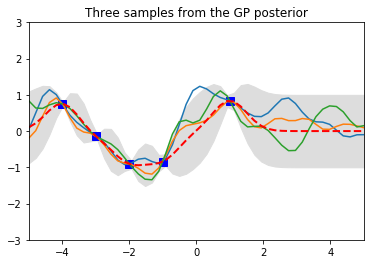

In [3]:
# Noiseless training data

######## ADD, DELETE OR CHANGE SOME POINTS IN THE TRAINING DATA 
Xtrain = np.array([-4, -3, -2, -1,1]).reshape(5,1) 
ytrain = np.sin(Xtrain)
########

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, sigma, l)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, sigma, l)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
plt.plot(Xtest, f_post)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([-5, 5, -3, 3])
plt.title('Three samples from the GP posterior')
plt.show()

**EXERCISE:**

We now write the code above as a function with as input variables the hyperparameters $l$ and $\sigma$ in the RBF kernel.

*Investigate the effect of changing the hyperparameters $l$ and $\sigma$ in the RBF kernel function $K$, keep in mind that the kernel function must be positive definite.
(tip: first keep $l$ stagnant and change $\sigma$, then try to keep $\sigma$ stagnant and change $l$)*

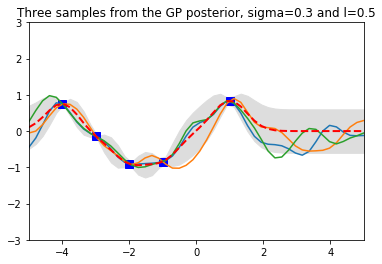

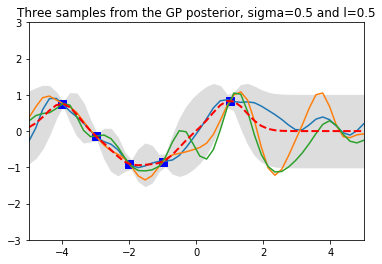

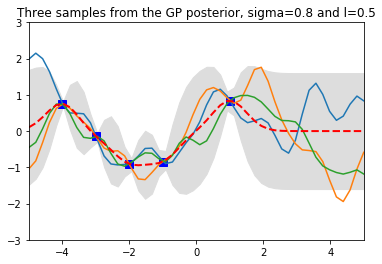

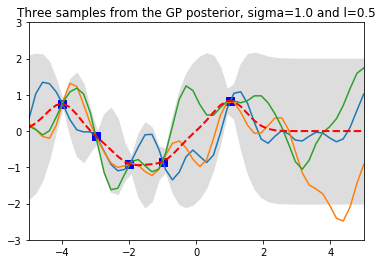

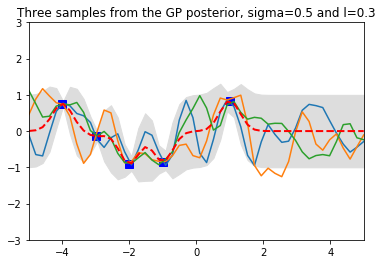

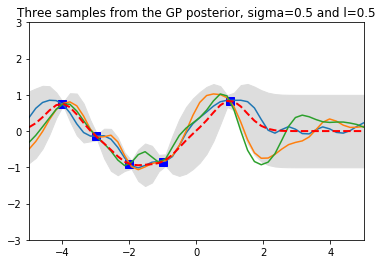

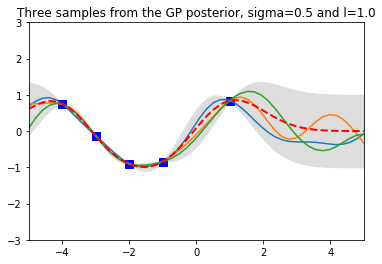

In [4]:
def add_para(sigma,l):
# Apply the kernel function to our training points
    K = kernel(Xtrain, Xtrain, sigma, l)
    L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
    K_s = kernel(Xtrain, Xtest, sigma, l)
    Lk = np.linalg.solve(L, K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

    K_ss = kernel(Xtest,Xtest,sigma,l) #this is K**


# Compute the standard deviation so we can plot it
    s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
    stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
    L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))
    plt.figure()
    plt.plot(Xtrain, ytrain, 'bs', ms=8)
    plt.plot(Xtest, f_post)
    plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
    plt.plot(Xtest, mu, 'r--', lw=2)
    plt.axis([-5, 5, -3, 3])
    plt.title('Three samples from the GP posterior, sigma={} and l={}'.format(sigma,l))
    plt.show()
    
    
###### INVESTIGATE THE EFFECT OF CHANGING THE HYPERPARAMETERS l AND sigma
sigma = np.array([0.3,0.5,0.8,1])
l = 0.5
for i in range(len(sigma)):
        add_para(sigma[i],l)


l = np.array([0.3,0.5,0.8,1])
sigma = 0.5
for i in range(len(l)):
        add_para(sigma,l[i])
######

The hyperparameter $l$ defines the influence of the neighbours. As $l$ increases, the influence of the neigbours increases, resulting in less variance, the fitted line will be smoother, because of this there is a higher chance of overfitting. If you would let $l$ approach infinity, a straight line will be obtained. $L$ also influences the confidence interval because changes in $l$ lead to changes in K which influences the mean and $\sigma$, so the choice of $l$ is tricky.  As $\sigma$ increases, the confidence interval decreases. You can choose these parameters by cross-validation.

**The Christmas Island Dataset**

The Christmas Island dataset is a dataset with the annual average of the atmospheric carbon dioxide concentrations (ppmv) measured from [Christmas Island](https://cdiac.ess-dive.lbl.gov/ftp/trends/co2/chr.dat) (Pacific). On every 15th day of the month between 1975 and 2007, 4 air samples were collected for each hour of that day. The average of these samples represents the value for that particular month in a certain year. For ease, we calculated the yearly averages to work with and this is the christmas dataset.

![Christmas_Island_map](./Christmas_Island_map.png)

For this dataset, the Rational Quadratic kernel is used
$$
\kappa(\textbf{x},\textbf{x}^{\prime}) = \bigg(1 + \frac{d(\textbf{x},\textbf{x}^{\prime})^{2}} {2\alpha\textit{l}^{2}}\bigg)^{-\alpha}
$$

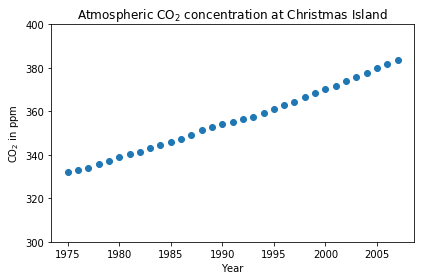

In [5]:
# import dataset
data = pd.read_csv('Christmas_Island.csv')
X = data.loc[:,'year'].values
y = data.loc[:,'average'].values

plt.scatter(X,y)
plt.ylim(300,400)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Christmas Island")
plt.tight_layout()
plt.show()

**EXERCISE:**

Split the data in a 50% training and 50% test set.  Fit a model using the <code>GaussianProcessRegressor()</code> (don't forget to normalize!), calculate the mean and standard deviation, evaluate testing accuracy and visualize your results. *(tip: use the test set to calculate the predictive score, but to make a plot you can predict the mean and stdv over the whole time period in little time steps)*

C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy of noiseless GP: 0.9976017191958072
The mean stdv on the predictions is: 0.9400454448299914


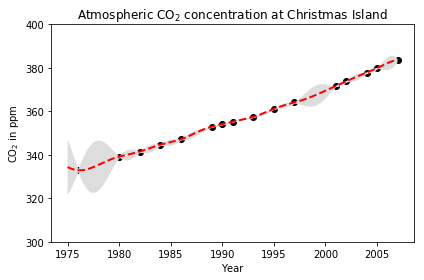

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic
# Split the data in training and test set
#(Imagine you have some missing values in the time series)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size = 0.5)

X_pred = np.arange(1975,2007,0.1)

gpr = GaussianProcessRegressor(kernel=RationalQuadratic(), n_restarts_optimizer=0, normalize_y=True, random_state=0)
gpr.fit(X_train.reshape(-1,1),y_train)

mu, stdv = gpr.predict(X_pred.reshape(-1,1), return_std=True)

print('Accuracy of noiseless GP:', gpr.score(X_test.reshape(-1,1),y_test))

# Unnormalize the stdv because we normalized this earlier, otherwise we'd have a very small and wrong standard deviation
stdv=(abs(mu-y.mean()))*stdv
print('The mean stdv on the predictions is:', np.mean(stdv))

plt.scatter(X_train,y_train, c='k')
plt.gca().fill_between(X_pred.flat, mu-2*stdv, mu+2*stdv, color="#dddddd", label='95% confidence interval')
plt.plot(X_pred, mu, 'r--', lw=2)
plt.ylim(300,400)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Christmas Island")
plt.tight_layout()
plt.show()

**EXERCISE:**

Reuse your code from above and extend it to the noisy case. Vary the noise term to investigate its effect.

In [7]:
a=0.02 #add noise
gpr_noise = GaussianProcessRegressor(kernel=RationalQuadratic(), alpha=a, n_restarts_optimizer=0, normalize_y=True, random_state=0)
gpr_noise.fit(X_train.reshape(-1,1),y_train)

mu_noise, stdv_noise = gpr_noise.predict(X_pred.reshape(-1,1), return_std=True)

print('Accuracy of noisy GP:', gpr_noise.score(X_test.reshape(-1,1),y_test))

# Unnormalize the stdv because we normalized this earlier, otherwise we'd have a very small and wrong standard deviation
stdv_noise=(abs(mu_noise-y.mean()))*stdv_noise


plt.gca().fill_between(X_pred.flat, mu_noise-2*stdv_noise, mu_noise+2*stdv_noise, color="#dddddd", label='95% confidence interval')
plt.scatter(X_train,y_train, c='k')
plt.plot(X_pred, mu_noise, 'r--', lw=2)
plt.ylim(300,400)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Christmas Island")
plt.tight_layout()
plt.show()

Accuracy of noisy GP: 0.9986361617917008




---

**GP in Active Learning**



Usually, time series aren't used for active learning, since you'd have to time travel to gather additional data. However, the Christmas Island dataset is a nice dataset to get a feeling wih active learning.


**EXERCISE:**

Use 20% of the data as your starting data (=training set) and reuse your code from the previous exercise (noiseless).

In [8]:

# set the seed so that your training looks like your initial data for active learning.
np.random.seed(301118)

# import dataset
data = pd.read_csv('Christmas_Island.csv')
X = data.loc[:,'year'].values
y = data.loc[:,'average'].values

# make your initial values (the training set), we could also have chosen some numbers to start with
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size = 0.2)

# we make a linspace to show the standard deviations nicely 
x = np.atleast_2d(np.linspace(1975, 2007, 384)).T

# RBF isn't used here because we have little datapoints and barely any neighbouring points,
# this would make the regression take the average and a standard deviation of 0 in certain points
gpr = GaussianProcessRegressor(kernel=RationalQuadratic(), n_restarts_optimizer=0, normalize_y=True, random_state=0)
gpr.fit(X_train.reshape(-1,1),y_train)

mu_test, stdv_test = gpr.predict(x, return_std=True)


# Unnormalize the stdv because we normalized this earlier, otherwise we'd have a very small and wrong standard deviation
stdv_new=(abs(mu_test-y.mean()))*stdv_test

# Illustration with standard deviation

plt.scatter(X_train,y_train, c='k')
plt.plot(x,mu_test,'b-')

plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([mu_test - 2*stdv_new,
                        (mu_test + 2*stdv_new)[::-1]]),
          alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlim(X.min(), X.max())
plt.ylim(200,400)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Christmas Island")
plt.tight_layout()
plt.show()


C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


**EXERCISE:**

Use the previous plot to evaluate where we are not certain about our predictions. Try to add the points from those regions in your training data. Do this at least 5 times or more if you feel like it.

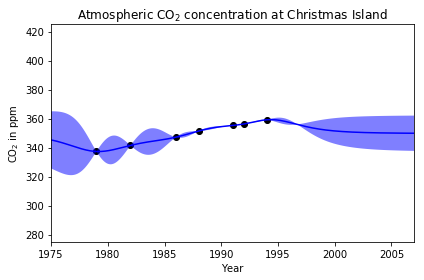

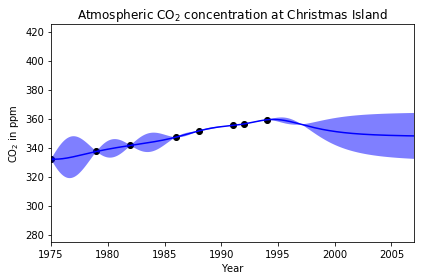

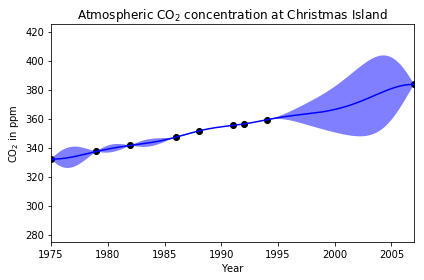

In [9]:
X_AL=X_train
y_AL=y_train
new=[1982,1975,2007,2004,2000]
for i in range(len(new)):
    X_AL=np.concatenate([X_AL,X[X==new[i]]])
    y_AL=np.concatenate([y_AL,y[X==new[i]]])

    gpr = GaussianProcessRegressor(kernel=RationalQuadratic(),n_restarts_optimizer=0, normalize_y=True, random_state=0)
    gpr.fit(X_AL.reshape(-1,1),y_AL)
  
    mu_AL, stdv_AL = gpr.predict(x, return_std=True)

    # Unnormalize stdv 
    stdv_AL_new=(abs(mu_AL-y.mean()))*stdv_AL

    # Illustration

    plt.scatter(X_AL,y_AL, c='k')
    plt.plot(x,mu_AL,'b-')

    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([mu_AL - 2*stdv_AL_new,
                            (mu_AL + 2*stdv_AL_new)[::-1]]),
              alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlim(X.min(), X.max())
    plt.ylim(275,425)
    plt.xlabel("Year")
    plt.ylabel(r"CO$_2$ in ppm")
    plt.title(r"Atmospheric CO$_2$ concentration at Christmas Island")
    plt.tight_layout()
    plt.show()


